# Strategy Simulation (fast version)

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import financial.data as fd
import financial.portfolio as fp
import financial.strategies.simulation as fss

import os

In [24]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
load_dotenv(dotenv_path=find_dotenv())

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


# Signals

In [25]:
import financial.strategies.technical.indicator as st

# Momentum
    
momentum1m = st.Momentum()
momentum1m.set_parameters({'delay': 20})

momentum3m = st.Momentum()
momentum3m.set_parameters({'delay': 60})

momentum4m = st.Momentum()
momentum4m.set_parameters({'delay': 84})

momentum6m = st.Momentum()
momentum6m.set_parameters({'delay': 126})

momentum8m = st.Momentum()
momentum8m.set_parameters({'delay': 168})

momentum9m = st.Momentum()
momentum9m.set_parameters({'delay': 189})
       
momentum1y = st.Momentum()
momentum1y.set_parameters({'delay': 252})
    
# Aggregation

indicator_ferrer = st.Mean()
indicator_ferrer.set_parameters({'components': [momentum4m.to_dict(), momentum6m.to_dict(), momentum8m.to_dict()]})
print(indicator_ferrer.to_dict())    
    
indicator_requejo = st.Mean() # st.Sum() # Average instead of sum to make it comparable
indicator_requejo.set_parameters({'components': [momentum1m.to_dict(), momentum3m.to_dict(), momentum6m.to_dict(), momentum9m.to_dict(), momentum1y.to_dict()]})
print(indicator_requejo.to_dict())  


{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 84}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 168}]}
{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 20}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 60}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 189}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 252}]}


In [26]:
from financial.momentum.indicators.exponentialIndicator import ExponentialRegressionIndicator

indicator_exponential = ExponentialRegressionIndicator()

# Strategies

In [27]:
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

# Asset Universe

universe_ferrer = ['XLI', 'XLF', 'XLV', 'XLK', 'XLC', 'XLU', 'XLY', 'XLB', 'XLE', 'XLP',
                    'TLT', 'TIP', 'IEF', 'SHY', 'AGG', 'VNQ', 'GLD', 'DBC'] # IAU excluded
    
universe_requejo = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'XOP',
                    'XHB', 'XME', 'XRT', 'XTL', 'TLT', 'DBC']
    
universe_ing = ['XLI', 'XLF', 'XLV', 'XLK', 'XLY', 'XLB', 'XLP', 
                'SPY', 'DJE', 'NASD', 
                'IOGP', 'IQQH', 'RBOT', 'HEAL', 
                'PHAU', 'LYTR', 'GLRE']

universe_ing_eur = ['ZPDM', 'ZPDI', 'ZPDS', 'ZPDH', 'ZPDT', 'ZPDD', 'ZPDF',
                   'SPY5', 'DJE', 'UST', 'LYTR', 'IQQH'] # , 'IOGP', 'GLRE', 'PHAU', 'HEAL', 'RBOT']

from typing import List

def universe_report(tickers: List[str]):
    for ticker in tickers:
        metadata = ds.get_metadata(ticker)
        #print(metadata)
        print(f"{ticker:4} {metadata['currency']} {metadata['since']} {metadata['isin']} {metadata['description']}")

print("HUGO FERRER'S UNIVERSE")
universe_report(universe_ferrer)

print("DANIEL REQUEJO'S UNIVERSE")
universe_report(universe_requejo)

print("ING'S UNIVERSE")
universe_report(universe_ing)

print("ING'S UNIVERSE [EUR]")
universe_report(universe_ing_eur)


# Asset ranking strategies

ferrer_refuge = None # refuge
ferrer_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=10), fsf.MinimumValueAssetFilter(threshold=0.0)] )
ferrer_allocation = fsa.FixedWeightAllocation(0.10)
ferrer_strategy = fsr.AssetRankingStrategy("HUGO FERRER'S STRATEGY", universe_ferrer,indicator_ferrer, ferrer_filter, ferrer_allocation, ferrer_refuge)
print(ferrer_strategy)

requejo_filter = fsf.TopKAssetFilter(k=3)
requejo_allocation = fsa.EqualWeightAllocation()
requejo_strategy = fsr.AssetRankingStrategy("DANIEL REQUEJO'S STRATEGY", universe_requejo, indicator_requejo, requejo_filter, requejo_allocation)    
print(requejo_strategy)

ferrer_strategy_ing = fsr.AssetRankingStrategy("ING @ Ferrer's strategy", universe_ing_eur, indicator_ferrer, ferrer_filter, ferrer_allocation)
print(ferrer_strategy_ing)

requejo_strategy_ing = fsr.AssetRankingStrategy("ING @ Requejo's strategy", universe_ing_eur, indicator_requejo, requejo_filter, requejo_allocation)
print(requejo_strategy_ing)





assets = {'DFF': 1.0}
target = fp.WeightedPortfolio.from_assets("Exp Refuge", assets)
exp_filter = fsf.TopKAssetFilter(k=7)
exp_allocation = fsa.EqualWeightAllocation()
exp_strategy = fsr.AssetRankingStrategy("Exponential Strategy", universe_ferrer, indicator_exponential, exp_filter, exp_allocation)
print(exp_strategy)


HUGO FERRER'S UNIVERSE
XLI  USD 02/01/2001 US81369Y7040 Industrial SPDR Select Sector ETF
XLF  USD 30/03/2001 US81369Y6059 Financial SPDR Select Sector ETF
XLV  USD 02/01/2001 US81369Y2090 Health Care SPDR Select Sector ETF
XLK  USD 02/01/2001 US81369Y8030 Technology SPDR Select Sector ETF
XLC  USD 20/06/2018 US81369Y8527 Communication Services SPDR Select Sector ETF
XLU  USD 27/11/2017 US81369Y8865 Utilities SPDR Select Sector ETF
XLY  USD 02/01/2001 US81369Y4070 Consumer Discretionary SPDR Select Sector ETF
XLB  USD 02/01/2001 US81369Y1001 Materials SPDR Select Sector ETF
XLE  USD 30/03/2001 US81369Y5069 Energy SPDR Select Sector ETF
XLP  USD 02/01/2001 US81369Y3080 Consumer Staples SPDR Select Sector ETF
TLT  USD 30/07/2002 US4642874329 US Bond 20+yr iShares ETF
TIP  USD 05/12/2003 US4642871762 US TIPS Bond iShares ETF
IEF  USD 07/07/2015 US4642874402 US Bond 7-10yr iShares ETF NASDAQ
SHY  USD 07/07/2015 US4642874576 US Bond 1-3yr iShares ETF NASDAQ
AGG  USD 29/09/2003 US4642872265 

# Porfolio performance

In [28]:
portfolio = fp.StockPortfolio("Stocks")
portfolio.add('$$$', '2001-01-01', 1000000, 1000000)

print(portfolio)

for ticker in portfolio.lots:
    print(portfolio.lots[ticker])
    
print(f"- Cost:  ${portfolio.cost():10.2f}")
print(f"- Value: ${portfolio.value(ds):10.2f}")
print(f"- Gain:  ${portfolio.gain(ds):>10.2f}  {100*portfolio.gain(ds)/portfolio.cost():>6.2f}%")
print()

fss.SimulationReport.value_report(ds,portfolio,start_year=2000)
print()
fss.SimulationReport.performance_report(ds,portfolio,start_year=2000)
fss.SimulationReport.performance_report_stocks(ds,portfolio,start_year=2000)


Stocks: ['$$$']
$$$: [{'index': '2001-01-01', 'stocks': 1000000, 'cost': 1000000}]
- Cost:  $1000000.00
- Value: $1000000.00
- Gain:  $      0.00    0.00%

           YEAR        Jan        Feb        Mar        Apr        May        Jun        Jul        Aug        Sep        Oct        Nov        Dec
  2000:       0.00                                                                                                
  2001: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2002: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2003: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2004: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00

In [29]:
import financial.portfolios.statistics as fps

assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
print(target)

print("Daily returns")
benchmark_returns = target.returns(ds,'2015-12-31','2023-12-31')
print(benchmark_returns)
print("Monthly returns")
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2016,2023)
print(benchmark_monthly_returns)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
print("Cumulative returns")
print(benchmark_cumulative_returns)


fss.SimulationReport.performance_report(ds, target, 2001)

print("\n Cumulative return")
fss.SimulationReport.cumulative_report(ds, target, 2001)


Target:
      ticker  weight  cost  isin description
^GSPC  ^GSPC     1.0  None  None        None
Daily returns
2016-01-04   -0.015304
2016-01-05    0.002012
2016-01-06   -0.013115
2016-01-07   -0.023700
2016-01-08   -0.010838
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Length: 2012, dtype: float64
Monthly returns
2016-01-31   -0.050735
2016-02-29   -0.004128
2016-03-31    0.065991
2016-04-30    0.002699
2016-05-31    0.015325
                ...   
2023-08-31   -0.017716
2023-09-30   -0.048719
2023-10-31   -0.021980
2023-11-30    0.089179
2023-12-31    0.044229
Name: return, Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.050735
2016-02-29   -0.054654
2016-03-31    0.007730
2016-04-30    0.010450
2016-05-31    0.025935
                ...   
2023-08-31    1.205378
2023-09-30    1.097933
2023-10-31    1.051821
2023-11-30    1.234801
2023-12-31    1.333645
Name: return, Length: 96

# Strategy simulation 

In [30]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy = exp_strategy #ferrer_strategy_ing #ferrer_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(+2,market) # +1 first day, -1 last day

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)
        
simulation = fss.FastStockStrategySimulation(ds, strategy, rebalancing, market)
#simulation.verbose = True  # verbose 30.4s vs. 15.4s without trading details
simulation.simulate(start_year=2016, end_year=2023)


STRATEGY
Exponential Strategy
- 18 asset universe: ['XLI', 'XLF', 'XLV', 'XLK', 'XLC', 'XLU', 'XLY', 'XLB', 'XLE', 'XLP', 'TLT', 'TIP', 'IEF', 'SHY', 'AGG', 'VNQ', 'GLD', 'DBC']
- Indicator: {'type': 'financial.momentum.indicators.exponentialIndicator.ExponentialRegressionIndicator', 'lookahead': 20, 'horizon': 90, 'model': 'exponential'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on 2
SIMULATING 2016...
+ Rebalance @ 2015-12-01
{'XLK': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLI': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLE': 0.14285714285714285, 'AGG': 0.14285714285714285, 'IEF': 0.14285714285714285}
+ Trade @ 2015-12-02
- Changes: {'XLE': 2150, 'VNQ': 1811, 'XLK': 3241, '$$$': -999748.4437942506, 'AGG': 1314, 'IEF': 1341, 'XLI': 2624, 'XLY': 1765}
- Rotation: 99.97%
+ Rebalance @ 2015-12-31
{'XLK': 0.14285714285714285, 'XLP': 0.14285714285714285, 'XLY': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLF': 0.14285714285714285, 

- Changes: {'XLF': -81, 'XLE': 3761, 'XLC': 22, 'XLB': -24, 'XLY': -11, '$$$': -335.35918617251446, 'XLI': 28, 'XLU': -2242, 'XLK': -27}
- Rotation: 14.67%
+ Rebalance @ 2021-02-01
{'XLE': 0.14285714285714285, 'XLF': 0.14285714285714285, 'XLB': 0.14285714285714285, 'DBC': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLC': 0.14285714285714285, 'XLK': 0.14285714285714285}
+ Trade @ 2021-02-02
- Changes: {'XLF': 21, 'DBC': 9495, 'XLE': -60, 'XLC': -5, 'XLB': 53, 'XLY': -896, '$$$': 140.2559986114793, 'XLI': 41, 'XLK': -11}
- Rotation: 15.08%
+ Rebalance @ 2021-03-01
{'XLE': 0.14285714285714285, 'XLF': 0.14285714285714285, 'DBC': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLC': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2021-03-02
- Changes: {'XLF': -117, 'DBC': 96, 'XLE': -448, 'XLC': 51, 'XLB': 62, 'XLY': 980, '$$$': 104.22836685192306, 'XLI': -1693, 'XLK': 97}
- Rotation: 16.34%
+ Rebalance @ 2021-04-01
{'XLE': 0.14285714285714285,

- Changes: {'DBC': -81, 'XLE': -191, 'XLP': 137, 'XLB': 17, '$$$': -74.45081901553203, 'XLU': -31, 'XLV': 32, 'GLD': 33}
- Rotation: 2.01%
+ Rebalance @ 2022-07-01
{'DBC': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLU': 0.14285714285714285, 'SHY': 0.14285714285714285, 'XLP': 0.14285714285714285, 'XLV': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2022-07-05
- Changes: {'DBC': 341, 'XLE': 242, 'XLP': -161, 'XLB': 147, '$$$': -98.63415336623439, 'XLU': -66, 'SHY': 1667, 'XLV': -98, 'GLD': -882}
- Rotation: 18.01%
+ Rebalance @ 2022-08-01
{'SHY': 0.14285714285714285, 'IEF': 0.14285714285714285, 'DBC': 0.14285714285714285, 'AGG': 0.14285714285714285, 'TIP': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLU': 0.14285714285714285}
+ Trade @ 2022-08-02
- Changes: {'DBC': 113, 'XLP': -1902, 'XLB': -1904, 'TIP': 1242, '$$$': 98.38035202017636, 'XLU': -46, 'IEF': 1381, 'XLV': -1073, 'XLE': -106, 'SHY': 73, 'AGG': 1394}
- Rotation: 43.74%
+ Rebalance @ 2022-09-01
{'XLY':

- Changes: {'DBC': 5721, 'XLC': -68, 'XLB': 23, '$$$': 200.23911666864296, 'XLK': -840, 'XLF': -15, 'XLE': -28, 'XLY': 4, 'XLI': 23}
- Rotation: 14.78%
+ Rebalance @ 2023-11-01
{'XLE': 0.14285714285714285, 'DBC': 0.14285714285714285, 'SHY': 0.14285714285714285, 'XLC': 0.14285714285714285, 'GLD': 0.14285714285714285, 'XLV': 0.14285714285714285, 'TIP': 0.14285714285714285}
+ Trade @ 2023-11-02
- Changes: {'DBC': -12, 'XLC': -17, 'XLB': -1828, 'TIP': 1365, '$$$': 48.00896072384785, 'XLV': 1117, 'GLD': 769, 'XLF': -4309, 'XLE': 17, 'XLY': -879, 'XLI': -1411, 'SHY': 1748}
- Rotation: 57.28%
+ Rebalance @ 2023-12-01
{'XLK': 0.14285714285714285, 'GLD': 0.14285714285714285, 'XLC': 0.14285714285714285, 'SHY': 0.14285714285714285, 'DBC': 0.14285714285714285, 'TIP': 0.14285714285714285, 'AGG': 0.14285714285714285}
+ Trade @ 2023-12-04
- Changes: {'DBC': 317, 'XLC': -70, 'TIP': -8, '$$$': -364.8766098021879, 'XLV': -1117, 'GLD': -10, 'XLK': 777, 'XLE': -1617, 'AGG': 1476}
- Rotation: 29.31%
+ Reba

In [31]:
simulation.portfolio_target_report()


2015-12-01: {'XLK': 0.14, 'XLY': 0.14, 'XLI': 0.14, 'VNQ': 0.14, 'XLE': 0.14, 'AGG': 0.14, 'IEF': 0.14}
2015-12-31: {'XLK': 0.14, 'XLP': 0.14, 'XLY': 0.14, 'VNQ': 0.14, 'XLF': 0.14, 'XLI': 0.14, 'XLB': 0.14}
2016-02-01: {'XLP': 0.14, 'TLT': 0.14, 'XLU': 0.14, 'XLV': 0.14, 'VNQ': 0.14, 'IEF': 0.14, 'XLK': 0.14}
2016-03-01: {'TLT': 0.14, 'XLU': 0.14, 'IEF': 0.14, 'GLD': 0.14, 'AGG': 0.14, 'XLP': 0.14, 'SHY': 0.14}
2016-04-01: {'GLD': 0.14, 'XLU': 0.14, 'TLT': 0.14, 'XLP': 0.14, 'IEF': 0.14, 'AGG': 0.14, 'TIP': 0.14}
2016-04-29: {'GLD': 0.14, 'XLU': 0.14, 'XLB': 0.14, 'XLE': 0.14, 'XLI': 0.14, 'XLP': 0.14, 'VNQ': 0.14}
2016-06-01: {'XLE': 0.14, 'XLB': 0.14, 'DBC': 0.14, 'XLF': 0.14, 'XLI': 0.14, 'VNQ': 0.14, 'XLY': 0.14}
2016-07-01: {'DBC': 0.14, 'XLE': 0.14, 'XLB': 0.14, 'VNQ': 0.14, 'XLU': 0.14, 'XLV': 0.14, 'TLT': 0.14}
2016-08-01: {'VNQ': 0.14, 'TLT': 0.14, 'DBC': 0.14, 'XLU': 0.14, 'XLE': 0.14, 'GLD': 0.14, 'XLV': 0.14}
2016-09-01: {'XLK': 0.14, 'VNQ': 0.14, 'TLT': 0.14, 'XLV': 0.14,

In [32]:
simulation.simulation_trading_report()

2015-12-02: 99.97% {'XLE': 2150, 'VNQ': 1811, 'XLK': 3241, '$$$': -999748.4437942506, 'AGG': 1314, 'IEF': 1341, 'XLI': 2624, 'XLY': 1765}
2016-01-04: 43.30% {'XLE': -2150, 'VNQ': -58, 'XLB': 3230, 'XLP': 2769, 'XLF': 7272, 'XLK': 25, 'XLY': 32, '$$$': -154.2222137451463, 'AGG': -1314, 'XLI': 15, 'IEF': -1341}
2016-02-02: 57.12% {'VNQ': -41, 'XLB': -3230, 'XLV': 1993, 'XLP': -167, 'XLF': -7272, 'TLT': 1013, 'XLK': -48, 'XLY': -1797, '$$$': 17.156978607177734, 'XLU': 2840, 'XLI': -2639, 'IEF': 1194}
2016-03-02: 43.66% {'VNQ': -1712, 'XLV': -1993, 'XLK': -3218, 'SHY': 1573, '$$$': 266.6331100463867, 'AGG': 1219, 'GLD': 1124, 'IEF': 26, 'XLP': -13, 'TLT': 21, 'XLU': 41}
2016-04-04: 15.13% {'SHY': -1573, '$$$': -108.64688873299747, 'AGG': 9, 'TIP': 1182, 'GLD': 45, 'IEF': 12, 'XLP': -56, 'TLT': 4, 'XLU': -142}
2016-05-02: 57.54% {'VNQ': 1634, '$$$': -204.54522705086856, 'AGG': -1228, 'TIP': -1182, 'GLD': -66, 'IEF': -1232, 'XLE': 2014, 'XLB': 2873, 'XLP': 34, 'TLT': -1038, 'XLU': 43, 'XLI':

In [33]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation (exponential strategy): {100*rotation:.2f}%")

Average monthly rotation (exponential strategy): 33.10%


In [34]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")
    

cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")



STRATEGY RETURNS
2016:   0.25%
2017:  17.55%
2018:  -1.67%
2019:  12.34%
2020:   3.16%
2021:  29.09%
2022:  -3.83%
2023:   4.56%

CUMULATIVE RETURNS
2016:   0.25%
2017:  17.84%
2018:  15.87%
2019:  30.17%
2020:  34.28%
2021:  73.34%
2022:  66.70%
2023:  74.30%


In [35]:
simulation.simulation_year_report()

2016
- Cost:  $1000000.00
- Value: $ 981939.35
- Gain:  $ -18060.65   -1.81%
2017
- Cost:  $1000000.00
- Value: $1192660.04
- Gain:  $ 192660.04   19.27%
2018
- Cost:  $1000000.00
- Value: $ 996887.94
- Gain:  $  -3112.06   -0.31%
2019
- Cost:  $1000000.00
- Value: $1123407.28
- Gain:  $ 123407.28   12.34%
2020
- Cost:  $1000000.00
- Value: $1031573.51
- Gain:  $  31573.51    3.16%
2021
- Cost:  $1000000.00
- Value: $1316312.14
- Gain:  $ 316312.14   31.63%
2022
- Cost:  $1000000.00
- Value: $1000550.30
- Gain:  $    550.30    0.06%
2023
- Cost:  $1000000.00
- Value: $1011294.68
- Gain:  $  11294.68    1.13%


In [36]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:             0.25%  -4.57%  -0.53%   3.19%   0.11%  -1.14%   1.19%   0.16%  -2.23%  -0.40%  -2.32%   5.36%   1.80%
Monthly cumulative returns
  2016:             0.25%  -4.57%  -5.08%  -2.05%  -1.94%  -3.05%  -1.90%  -1.74%  -3.93%  -4.32%  -6.54%  -1.52%   0.25%

SERIES
Monthly returns
2016-01-31   -0.045712
2016-02-29   -0.005318
2016-03-31    0.031930
2016-04-30    0.001120
2016-05-31   -0.011353
                ...   
2023-08-31   -0.021095
2023-09-30   -0.036519
2023-10-31   -0.030803
2023-11-30    0.042871
2023-12-31    0.023868
Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.045712
2016-02-29   -0.050787
2016-03-31   -0.020479
2016-04-30   -0.019381
2016-05-31   -0.030514
                ...   
2023-08-31    0.748121
2023-09-30    0.684282
2023-10-31    0.632402
2023-11-30    0.702385
2023-12-31    0.743018
Length: 96, dtype: float64
CPU times: user 28.3 s, sys: 17.5 ms, total: 28.3 s
Wall time: 28.3 s


In [37]:
import pandas as pd
benchmark_series = pd.Series(benchmark_monthly_returns)
difference = monthly_returns - benchmark_series
print(difference)

print("Better than benchmark")
print(sum(difference>0))
print(difference[difference>0])
print(sum(difference[difference>0]))

print("Worse than benchmark")
print(sum(difference<0))
print(difference[difference<0])
print(sum(difference[difference<0]))

2016-01-31    0.005023
2016-02-29   -0.001190
2016-03-31   -0.034061
2016-04-30   -0.001579
2016-05-31   -0.026677
                ...   
2023-08-31   -0.003379
2023-09-30    0.012201
2023-10-31   -0.008823
2023-11-30   -0.046308
2023-12-31   -0.020361
Length: 96, dtype: float64
Better than benchmark
36
2016-01-31    0.005023
2016-06-30    0.010999
2016-11-30    0.019447
2017-04-30    0.006223
2017-05-31    0.010355
2017-08-31    0.007645
2017-10-31    0.008134
2017-12-31    0.001507
2018-03-31    0.008197
2018-04-30    0.001499
2018-06-30    0.004590
2018-10-31    0.019144
2018-12-31    0.081690
2019-03-31    0.004584
2019-05-31    0.002460
2019-08-31    0.059263
2020-02-29    0.002741
2020-03-31    0.074676
2020-09-30    0.011458
2020-10-31    0.005022
2021-02-28    0.067828
2021-04-30    0.006912
2021-05-31    0.028861
2021-09-30    0.006331
2021-12-31    0.004158
2022-01-31    0.030391
2022-02-28    0.020048
2022-03-31    0.009360
2022-04-30    0.066520
2022-05-31    0.028770
2022-

In [38]:
drawdown = fps.MaximumDrawdown().get_series(monthly_returns)
print(drawdown)
print(min(drawdown))

benchmark_drawdown = fps.MaximumDrawdown().get_series(benchmark_returns) # benchmark_monthly_returns)
print(benchmark_drawdown)
print(min(benchmark_drawdown))

2016-01-31   -0.045712
2016-02-29   -0.050787
2016-03-31   -0.020479
2016-04-30   -0.019381
2016-05-31   -0.030514
                ...   
2023-08-31   -0.021095
2023-09-30   -0.056843
2023-10-31   -0.085895
2023-11-30   -0.046707
2023-12-31   -0.023953
Length: 96, dtype: float64
-0.1540579115494235
2016-01-04   -0.015304
2016-01-05   -0.013322
2016-01-06   -0.026263
2016-01-07   -0.049341
2016-01-08   -0.059645
                ...   
2023-12-22   -0.008742
2023-12-26   -0.004547
2023-12-27   -0.003123
2023-12-28   -0.002754
2023-12-29   -0.005573
Length: 2012, dtype: float64
-0.3392496000265328


In [39]:
%%time

simulation.simulation_performance_report()

         return     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:    0.25%    0.25%  -4.57%  -0.53%   3.19%   0.11%  -1.14%   1.19%   0.16%  -2.23%  -0.40%  -2.32%   5.36%   1.80%
  2017:   17.84%   17.55%   1.52%   1.97%  -0.36%   1.53%   2.19%  -0.38%   1.43%   0.82%   1.40%   3.03%   2.03%   1.13%
  2018:   15.87%   -1.67%   5.17%  -4.65%  -1.87%   0.42%   0.92%   0.94%   0.62%   2.21%  -0.23%  -5.03%   1.26%  -1.01%
  2019:   30.17%   12.34%   2.18%   0.33%   2.25%   1.65%  -6.33%   5.01%   1.29%   4.12%  -0.53%   0.46%  -0.86%   2.59%
  2020:   34.28%    3.16%  -3.02%  -8.14%  -5.04%   0.80%   0.85%   0.34%   4.83%   6.71%  -2.78%  -2.26%   9.52%   2.69%
  2021:   73.34%   29.09%  -1.20%   9.39%   3.65%   5.93%   3.43%  -0.17%   2.13%   0.95%  -4.12%   4.59%  -2.74%   4.78%
  2022:   66.70%   -3.83%  -2.22%  -1.13%   4.51%  -2.14%   2.88%  -7.04%   3.41%  -1.65%  -7.41%   7.27%   4.20%  -3.37%
  2023:   74.30%    4.56%

In [40]:
%%time

print("MONTHLY RETURNS")
fss.SimulationReport.simulation_report(monthly_returns, fss.accumulate_return)
print("CUMULATIVE RETURNS")
fss.SimulationReport.simulation_report(cumulative_returns, fss.accumulate_last)
print("SIMULATION DRAWDOWN")
fss.SimulationReport.simulation_report(drawdown, fss.accumulate_min)

MONTHLY RETURNS
          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:    0.25%    0.25%  -4.57%  -0.53%   3.19%   0.11%  -1.14%   1.19%   0.16%  -2.23%  -0.40%  -2.32%   5.36%   1.80%
  2017:   17.84%   17.55%   1.52%   1.97%  -0.36%   1.53%   2.19%  -0.38%   1.43%   0.82%   1.40%   3.03%   2.03%   1.13%
  2018:   15.87%   -1.67%   5.17%  -4.65%  -1.87%   0.42%   0.92%   0.94%   0.62%   2.21%  -0.23%  -5.03%   1.26%  -1.01%
  2019:   30.17%   12.34%   2.18%   0.33%   2.25%   1.65%  -6.33%   5.01%   1.29%   4.12%  -0.53%   0.46%  -0.86%   2.59%
  2020:   34.28%    3.16%  -3.02%  -8.14%  -5.04%   0.80%   0.85%   0.34%   4.83%   6.71%  -2.78%  -2.26%   9.52%   2.69%
  2021:   73.34%   29.09%  -1.20%   9.39%   3.65%   5.93%   3.43%  -0.17%   2.13%   0.95%  -4.12%   4.59%  -2.74%   4.78%
  2022:   66.70%   -3.83%  -2.22%  -1.13%   4.51%  -2.14%   2.88%  -7.04%   3.41%  -1.65%  -7.41%   7.27%   4.20%  -3.37%
  2023:  

STRATEGY vs. BENCHMARK


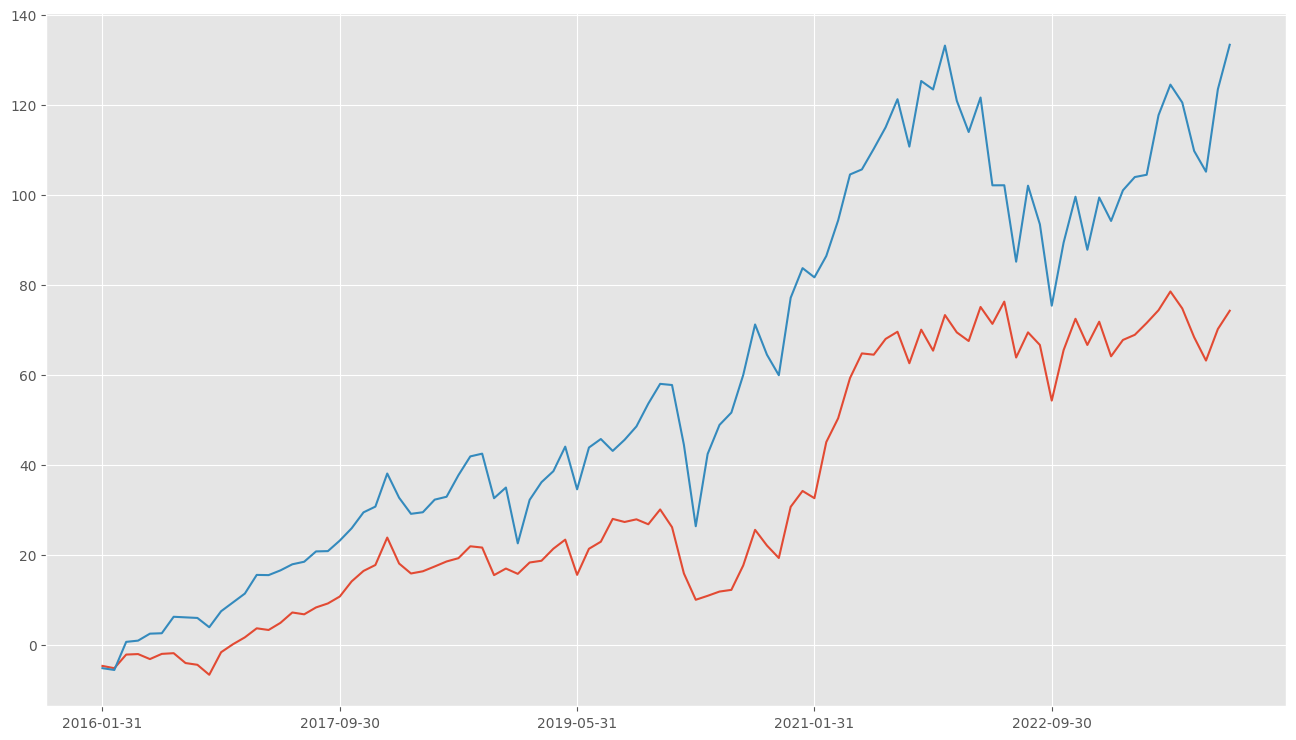

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()
print("STRATEGY vs. BENCHMARK")